# Customer Lifetime Value Analysis

The marketing team at wants to know how much can they spend on acquiring new customers to the platform. Therefore,they need CLV Analysis on an all customers for theor entire customer relation duration.

In [1]:
import DataPipeline as dp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
plt.style.use("seaborn-v0_8-talk")

## Initialize Data pipeline

In [2]:
pipeline = dp.DataPipeline()

10:35:27 Initializing pipeline
10:35:27 Creating customer cohorts view in database
10:35:27 Creating top partners by sales view in database
10:35:27 Creating partner segments and order quantity view in database
10:35:27 Creating Lifespan, Frequency, sales value view in database
10:35:27 Done


## Retention Rate Analysis

In [3]:
query = """ 
            SELECT 
                MONTHS_SINCE_FIRST_PURCHASE AS M,
                (CAST( COUNT(MONTHS_SINCE_FIRST_PURCHASE) AS REAL) / 
                CAST((SELECT COUNT(DISTINCT(USERID)) FROM CUSTOMER_COHORT) AS REAL))*100 AS RETENTION_RATE,
                COUNT(MONTHS_SINCE_FIRST_PURCHASE) as CUSTOMER_COUNT
            FROM CUSTOMER_COHORT
            GROUP BY MONTHS_SINCE_FIRST_PURCHASE
        """
retention_rate = pipeline.execute_query(query=query)

In [4]:
retention_rate

,M,RETENTION_RATE,CUSTOMER_COUNT
0,0,100.000000,123208
1,1,14.587527,17973
2,2,12.001656,14787
3,3,10.594280,13053
4,4,9.544835,11760
5,5,8.895526,10960
6,6,7.850140,9672
7,7,7.306344,9002
8,8,6.209012,7650
9,9,5.468801,6738


### Ploting retention curve

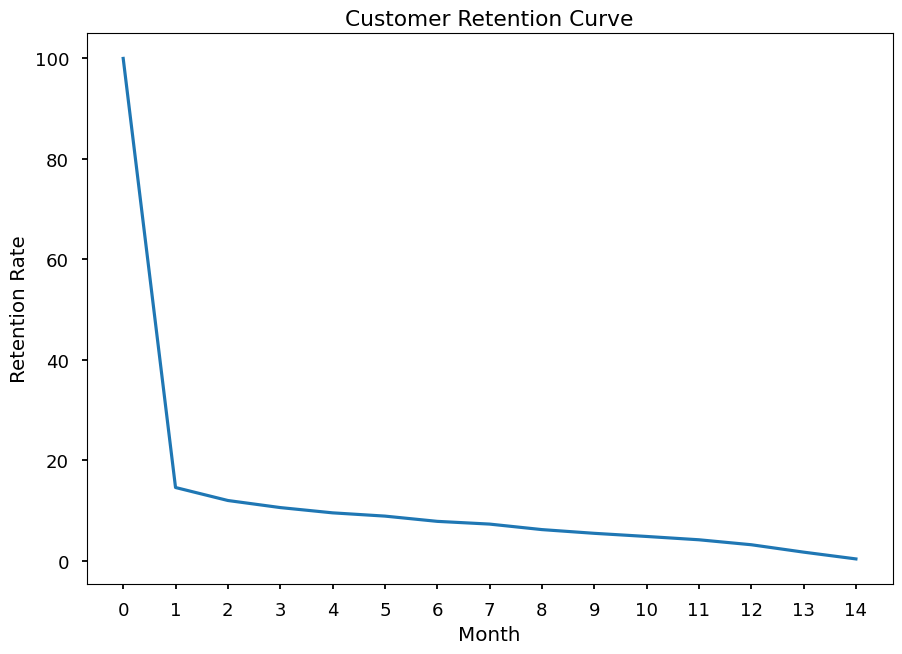

In [5]:
plt.plot(retention_rate.M,  retention_rate.RETENTION_RATE)
plt.title("Customer Retention Curve")
plt.ylabel("Retention Rate")
plt.xlabel("Month")
plt.xticks(ticks=retention_rate.M)
plt.show()

#### Inference

- The customer base is **123,208**. These customers are users who have purchased at least once.
- Out of this customer base, the M1 retention rate is **14.59%**. This means that **14.59% of customers (17,973)** return to purchase again one month after their first purchase. Conversely, **more than 80% of customers** do not return to purchase in the first month after their first purchase. Customers **could be encouraged to continue purchasing** after their first purchase, perhaps through discounts for subsequent months, and impproved customer experience.
- The maximum customer lifetime is **14 months**.

## Cohort Analysis

In [6]:
query= """
        SELECT 
                USERID,
                MONTHS_SINCE_FIRST_PURCHASE AS M,
                COHORT_DATE as cohort
        FROM CUSTOMER_COHORT
      """

cohorts_df = pipeline.execute_query(query=query)

cohorts_df = (
    cohorts_df.groupby(["cohort", "M"])[["USERID"]]
    .nunique()
    .assign(
        total=lambda x: x.groupby("cohort")[["USERID"]].transform(lambda x: x.iloc[0]),
        retention=lambda x: 100 * x.USERID / x.total,
    )
    .reset_index()
)

cohorts_df.rename(columns={"USERID": "customer_count"}, inplace=True)

In [7]:
cohorts_df

,cohort,M,customer_count,total,retention
0,2022-09-01,0,4134,4134,100.000000
1,2022-09-01,1,1220,4134,29.511369
2,2022-09-01,2,1090,4134,26.366715
3,2022-09-01,3,849,4134,20.537010
4,2022-09-01,4,898,4134,21.722303
...,...,...,...,...,...
115,2023-09-01,1,903,7502,12.036790
116,2023-09-01,2,474,7502,6.318315
117,2023-10-01,0,7123,7123,100.000000
118,2023-10-01,1,531,7123,7.454724


In [8]:
cohorts_pivot = cohorts_df[["cohort", "M", "retention"]].pivot(
    columns="M", index="cohort"
)["retention"]

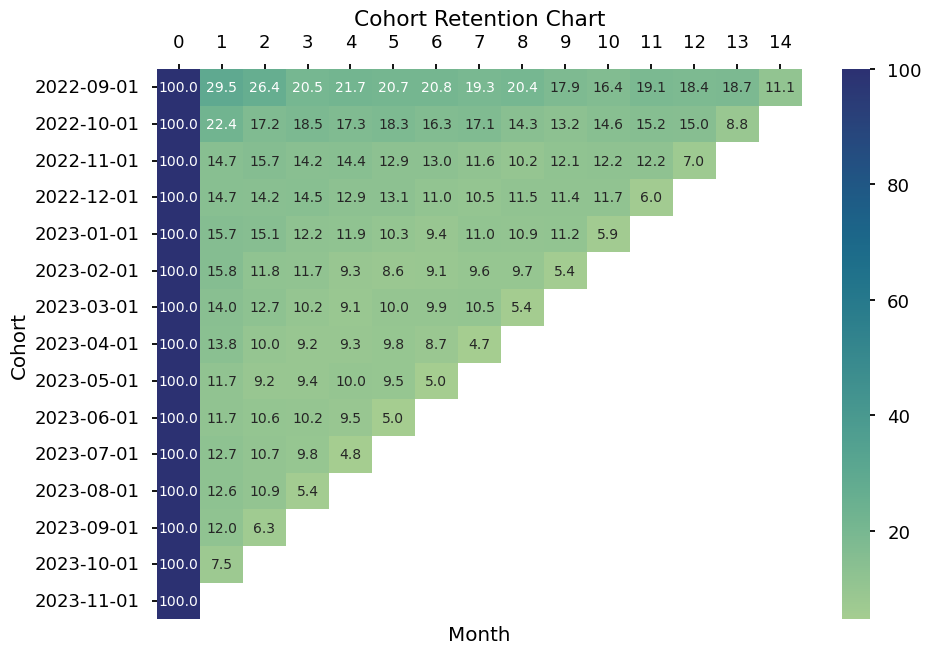

In [9]:
g = sns.heatmap(cohorts_pivot, cmap="crest", annot=True, fmt=".1f")
g.axes.xaxis.set_ticks_position("top")
plt.title("Cohort Retention Chart")
plt.xlabel("Month")
plt.ylabel("Cohort")
plt.show()

#### Inference

- Retention is sustained after M1. It is crucial to reduce the drop after M0 to increase the likelihood of retaining customers for greater revenue.
- The cohort from **September 2022** (2022-09) is the most retained cohort, with retention sustained around **20%** up to M9 (the tenth month).
- There was a drop in retention in **December** for the 2022-09 and 2022-10 cohorts. In December, the 2022-09 cohort dropped by about **6%**, and the 2022-10 cohort dropped by about **3%**.
- There is a noticeable **4-7% drop** in retention during **November** across all cohorts (see diagonal from cohort 2023-10, M1 to cohort 2022-09, M14). What happens in November? The company could consider strategies such as discounted sales or special offers in October, November, and December to sustain or boost retention.
- An increase in retention is observable during the **fall months** (August, September, October). The company could capitalize on this opportunity to boost sales during these months.

## Customer Lifetime Value 

### Read customer lifespan, frequency, sales values

In [10]:
query = "SELECT * FROM LIFESPAN_FREQUENCY_SALES"
lfs = pipeline.execute_query(query=query)

Check the data types of columns and converting them appropriately

In [11]:
lfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123210 entries, 0 to 123209
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   userId          123210 non-null  int64  
 1   COHORT_DATE     123210 non-null  object 
 2   purchase_month  123210 non-null  object 
 3   lifespan        123210 non-null  int64  
 4   frequency       123210 non-null  int64  
 5   currency        123210 non-null  object 
 6   average_sales   123210 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 6.6+ MB


In [12]:
lfs.rename(columns={"COHORT_DATE":"first_purchase_month"}, inplace=True)
lfs["userId"]=lfs["userId"].astype("object")
lfs["purchase_month"] =pd.to_datetime(lfs["purchase_month"])
lfs["first_purchase_month"] =pd.to_datetime(lfs["first_purchase_month"])

In [13]:
lfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123210 entries, 0 to 123209
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   userId                123210 non-null  object        
 1   first_purchase_month  123210 non-null  datetime64[ns]
 2   purchase_month        123210 non-null  datetime64[ns]
 3   lifespan              123210 non-null  int64         
 4   frequency             123210 non-null  int64         
 5   currency              123210 non-null  object        
 6   average_sales         123210 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 6.6+ MB


### Explore the transaction data 

Convert all **SEK** sales to **Euro** assuming a convertion rate

In [14]:
sek_euro_convertion_rate = 0.088

lfs["average_sales_euro"] = lfs.apply(
    lambda x: (
        x["average_sales"] * sek_euro_convertion_rate
        if x["currency"] == "sek"
        else x["average_sales"]
    ),
    axis=1,
)
lfs.drop(columns=["currency", "average_sales"], inplace=True)
lfs = lfs.groupby(["userId", "purchase_month","first_purchase_month"], as_index=False).agg(
    {"lifespan": "mean", "frequency": "sum", "average_sales_euro": "mean"}
)
lfs.head(10)

,userId,purchase_month,first_purchase_month,lifespan,frequency,average_sales_euro
0,65326324392533,2023-05-01,2023-05-01,0.0,1,250.000000
1,168982159910603,2023-08-01,2023-08-01,0.0,1,650.000000
2,219034330643057,2023-11-01,2022-11-01,12.0,3,673.333333
3,271311745575070,2022-12-01,2022-12-01,0.0,1,1180.000000
4,327509841715406,2022-10-01,2022-10-01,0.0,1,1800.000000
5,332400596016082,2023-04-01,2023-04-01,0.0,1,400.000000
6,391633657998574,2022-11-01,2022-11-01,0.0,1,490.000000
7,406087302631582,2023-08-01,2023-08-01,0.0,2,1045.000000
8,472654236140424,2023-11-01,2023-08-01,3.0,2,1025.000000
9,494869758008189,2023-09-01,2023-04-01,5.0,2,688.000000


Check the distributions of lifespan, freqency and average_sales_euros

In [15]:
def show_dist_plot(var_data, title, ylabel, xlabel):
    sns.kdeplot(x=var_data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # Show the mean, median, mode and max
    plt.axvline(
        x=var_data.mean(),
        color="cyan",
        linestyle="dashed",
        linewidth=2,
        label=f"Mean ({var_data.mean():.2f})",
    )
    plt.axvline(
        x=var_data.median(),
        color="red",
        linestyle="dashed",
        linewidth=2,
        label=f"Median ({var_data.median():.2f})",
    )
    plt.axvline(
        x=var_data.mode()[0],
        color="yellow",
        linestyle="dashed",
        linewidth=2,
        label=f"Mode ({var_data.mode()[0]:.2f})",
    )
    plt.axvline(
        x=var_data.max(),
        color="gray",
        linestyle="dashed",
        linewidth=2,
        label=f"Max ({var_data.max()})",
    )
    plt.axvline(
        x=var_data.min(),
        color="gray",
        linestyle="dashed",
        linewidth=2,
        label=f"Min ({var_data.min()})",
    )
    plt.xlim(
       (var_data.min(),var_data.max())
    )
    plt.legend()
    plt.show()

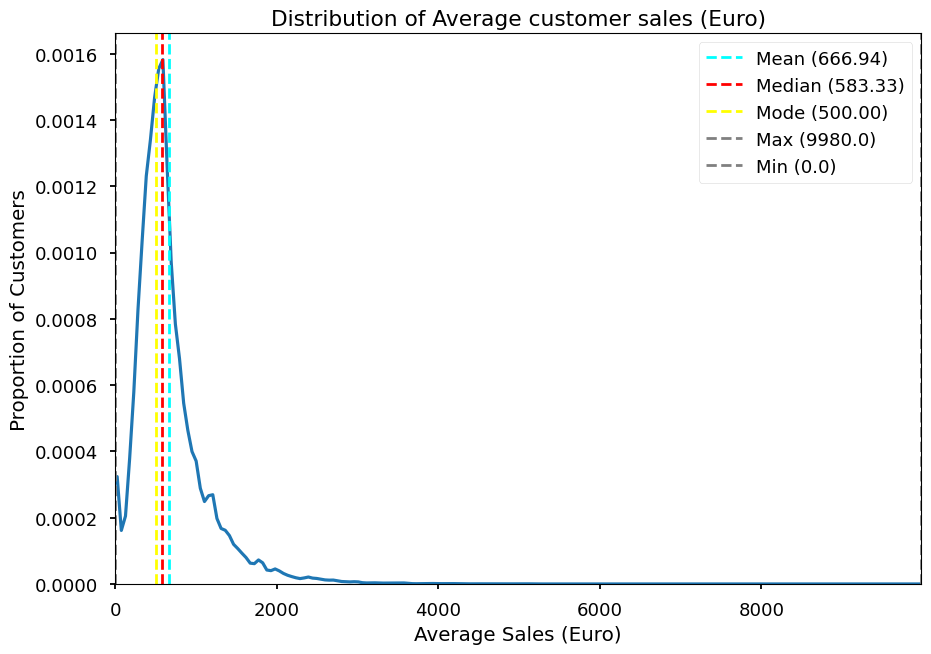

In [16]:
show_dist_plot(
    var_data=lfs["average_sales_euro"],
    title="Distribution of Average customer sales (Euro)",
    ylabel="Proportion of Customers",
    xlabel="Average Sales (Euro)",
)

#### Inference

The distribution of average customer sales is left-skewed. Although the maximum customer sales reach 9,980 euros, the average is 666 euros, with the majority of customers having sales around 500 euros. 

`Question`

The minimum lifetime sales for some customers (47778) is zero. Does this indicate that these orders were free? Customers might have received items through promotions or loyalty programs without direct purchases, leading to zero sales in the data

In [17]:
lfs[lfs["average_sales_euro"]==0]

,userId,purchase_month,first_purchase_month,lifespan,frequency,average_sales_euro
58,5120141954573712,2022-12-01,2022-12-01,0.0,1,0.0
74,6207944155636470,2023-03-01,2023-03-01,0.0,1,0.0
100,8039853486500445,2023-06-01,2023-05-01,1.0,2,0.0
106,8423360510494468,2023-02-01,2023-02-01,0.0,1,0.0
119,9292090121837218,2022-11-01,2022-11-01,0.0,1,0.0
...,...,...,...,...,...,...
123071,9213804441424331690,2023-07-01,2023-07-01,0.0,2,0.0
123099,9215015255602677840,2022-11-01,2022-11-01,0.0,1,0.0
123130,9217410302401760993,2022-11-01,2022-11-01,0.0,1,0.0
123184,9222211130855761329,2022-11-01,2022-11-01,0.0,1,0.0


In [18]:
pipeline.execute_query("""SELECT COUNT(*) AS Zero_Sales_Customers
FROM (
    SELECT userId
    FROM orders
    GROUP BY userId
    HAVING SUM(sales) = 0
) """)

,Zero_Sales_Customers
0,4778


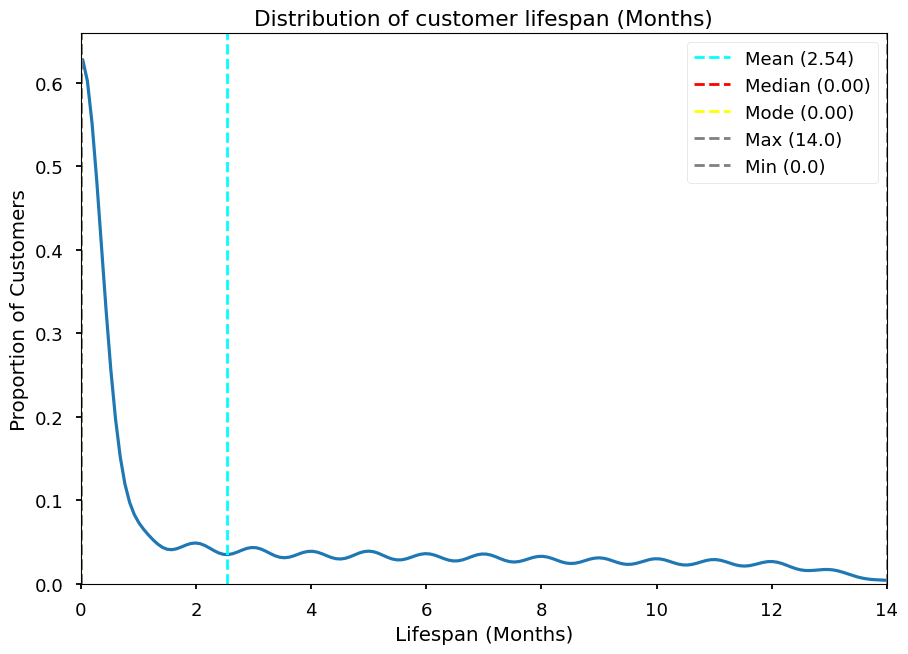

In [19]:
show_dist_plot(
    var_data=lfs["lifespan"],
    xlabel="Lifespan (Months)",
    ylabel="Proportion of Customers",
    title="Distribution of customer lifespan (Months)",
)

#### Inference

Similar to the retention curve, the distribution of customer lifespan is left-skewed. The maximum lifespan is 14 months after the first purchase, with an average of 2.54 months.

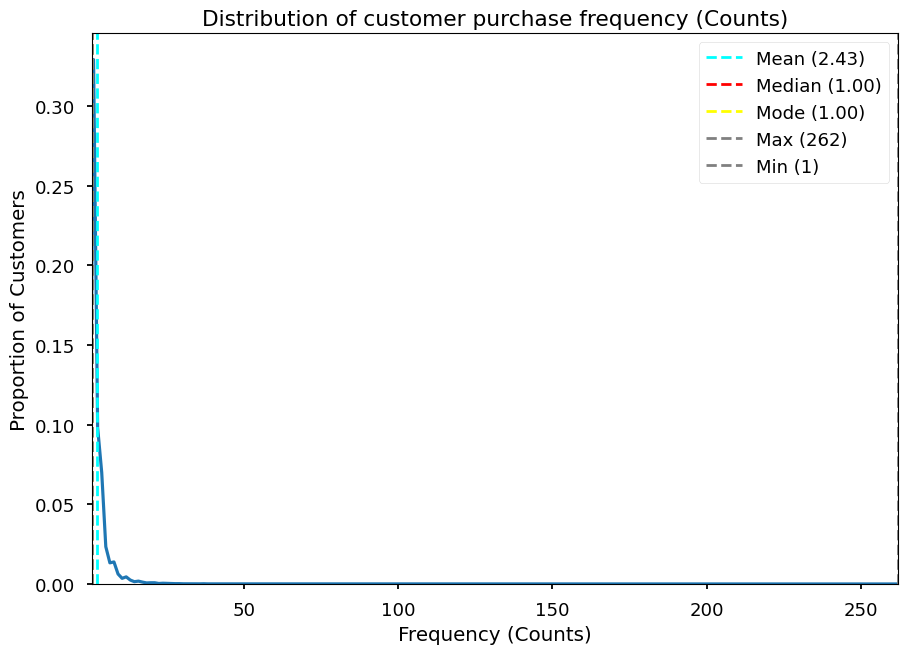

In [20]:
show_dist_plot(
    var_data=lfs["frequency"],
    xlabel="Frequency (Counts)",
    ylabel="Proportion of Customers",
    title="Distribution of customer purchase frequency (Counts)",
)

#### Inference

While most customers make only one purchase, the average purchase frequency is 2.43, with at least one customer having made 250 purchases.

In [21]:
lfs[lfs["frequency"]==262]

,userId,purchase_month,first_purchase_month,lifespan,frequency,average_sales_euro
5389,402089433377497830,2023-11-01,2022-09-01,14.0,262,567.198473


## Compute Customer Lifetime Value
Compute **CV** as:
$ \text{Average Frequency} \times \text{Average Sales (Euros)}$

Compute **CLV** as:
$ \text{CLV} = \text{Average Lifespan} \times \text{Average Frequency} \times \text{Average Sales (Euros)}$

In [22]:
lfs["CV"] = lfs["frequency"] * lfs["average_sales_euro"]
customer_clv = lfs.copy()

customer_clv.sort_values(by="CV", ascending=False)

,userId,purchase_month,first_purchase_month,lifespan,frequency,average_sales_euro,CV
5389,402089433377497830,2023-11-01,2022-09-01,14.0,262,567.198473,148606.0
91485,6836716632121424733,2023-11-01,2022-09-01,14.0,63,856.031746,53930.0
69095,5156756655607387559,2023-10-01,2022-09-01,13.0,34,1555.588235,52890.0
77438,5786196591665482994,2023-10-01,2022-09-01,13.0,76,668.421053,50800.0
26437,1963435673590959229,2023-11-01,2022-10-01,13.0,39,1171.794872,45700.0
...,...,...,...,...,...,...,...
41087,3052559157775286154,2022-11-01,2022-11-01,0.0,1,0.000000,0.0
80374,6002307372811900218,2022-11-01,2022-11-01,0.0,1,0.000000,0.0
41114,3055220048359771058,2022-10-01,2022-10-01,0.0,1,0.000000,0.0
80370,6002096817342340296,2023-09-01,2023-09-01,0.0,1,0.000000,0.0


In [23]:
CLV = (
    customer_clv["lifespan"].mean()
    * customer_clv["frequency"].mean()
    * customer_clv["average_sales_euro"].mean()
)

CLV

4130.549767444847

Assuming a profit margin

In [24]:
profit_margin = 0.05
CLV * profit_margin

206.52748837224237

## `Now answering the Marketing question`

### Inference

- The average customer generates **4,130 euros** in sales.
- Assuming a profit margin of **5%**, the profit from an average customer is **206.53 euros**. Therefore, the marketing team should not spend more than **206.53 euros** to acquire a new customer.

## Using probabilistic models to estimate future CLV

Given the skewness in customer lifespan, purchase frequency, and average sales, and the fact that the CLV formula uses averages, on historical data, this CLV estimate may not be entirely reliable when looking into the future. The is the need to explore more advanced methods that leverage customer behavior trends and enable more confident estimation of Customer Lifetime Values (CLVs). Unlike subscription-based models, where retention is more predictable, customers in this case can leave and return at any time. This [video](https://www.youtube.com/watch?v=guj2gVEEx4s&ab_channel=FirstMarkCapital) emphasizes the importance of probabilistic modeling for customer behavior in non-subscription-based businesses.


The [lifetimes](https://lifetimes.readthedocs.io/en/latest/index.html) marketing science python libraries will be used in these probalistic estimations. We use the **BetaGeoFitter** and **GammaGammaFitter** models in lifetimes package.



### Computing T (Age of Customer)
`T` is the age of customers at the end of the period under study. So in our data, this is the age of the customer in months from first purchase date and the last transation dataset

In [25]:
trans_data = lfs.copy()
period_end_date =trans_data["purchase_month"].max()

trans_data["T"] = trans_data["first_purchase_month"].apply(
    lambda x: (period_end_date.to_period("M") - x.to_period("M")).n
)
trans_data = trans_data[["userId", "frequency", "lifespan", "T", "average_sales_euro","CV"]]

### Predicting future purchases and probability that the customer is alive

The model requires repeat customers only, i.e, customer who purchased again after their first transaction


In [26]:
trans_data=trans_data[trans_data.lifespan>0]
trans_data.set_index("userId")

,frequency,lifespan,T,average_sales_euro,CV
userId,,,,,
219034330643057,3,12.0,12,673.333333,2020.0
472654236140424,2,3.0,3,1025.000000,2050.0
494869758008189,2,5.0,7,688.000000,1376.0
857319303011182,5,13.0,13,556.000000,2780.0
1010263118317948,2,4.0,4,850.000000,1700.0
...,...,...,...,...,...
9223090445069821952,6,8.0,13,983.333333,5900.0
9223097207332177627,2,2.0,8,470.000000,940.0
9223113765943846674,4,4.0,11,500.000000,2000.0


In [27]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import (
    plot_frequency_recency_matrix,
    plot_probability_alive_matrix,
    plot_period_transactions,
)

bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(
    frequency=trans_data["frequency"], recency=trans_data["lifespan"], T=trans_data["T"]
)
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.111422,0.005687,1.100276,1.122569
alpha,1.642640,0.012565,1.618013,1.667267
a,0.129779,0.001918,0.126018,0.133539
b,0.720848,0.006422,0.708261,0.733435


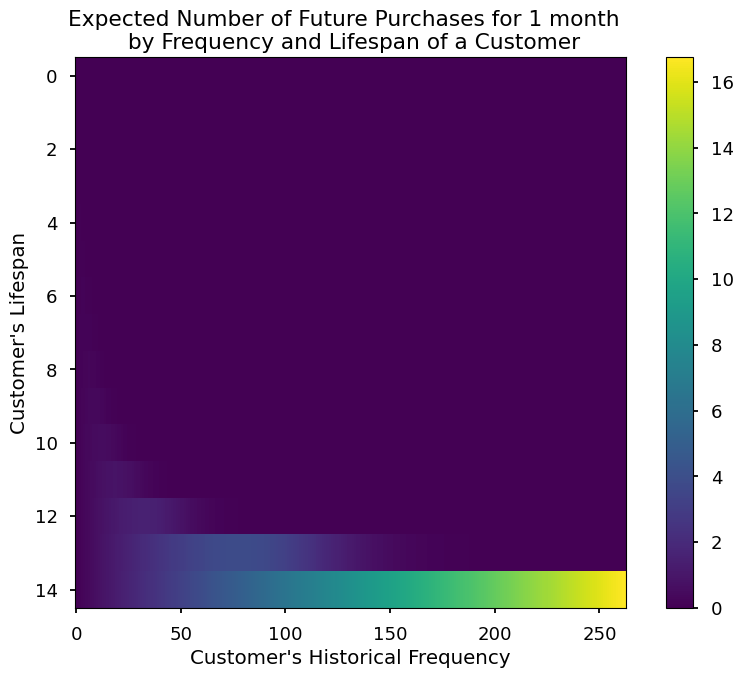

In [28]:
time_unit = 1
plot_frequency_recency_matrix(bgf, T=time_unit)
plt.title(f"Expected Number of Future Purchases for {time_unit} month  \n by Frequency and Lifespan of a Customer")
plt.ylabel("Customer's Lifespan")
plt.show()

#### Inference

* Customers who made 100 or more purchases by their 14th month with the company are likely to make 8 to 16 purchases in the following month. 

* Customers who made 25 to 100 purchases recently (between months 10 and 13) are likely to make 2 to 5 purchases next month. However, we do not know the probability that these customers will be alive (with next month). 

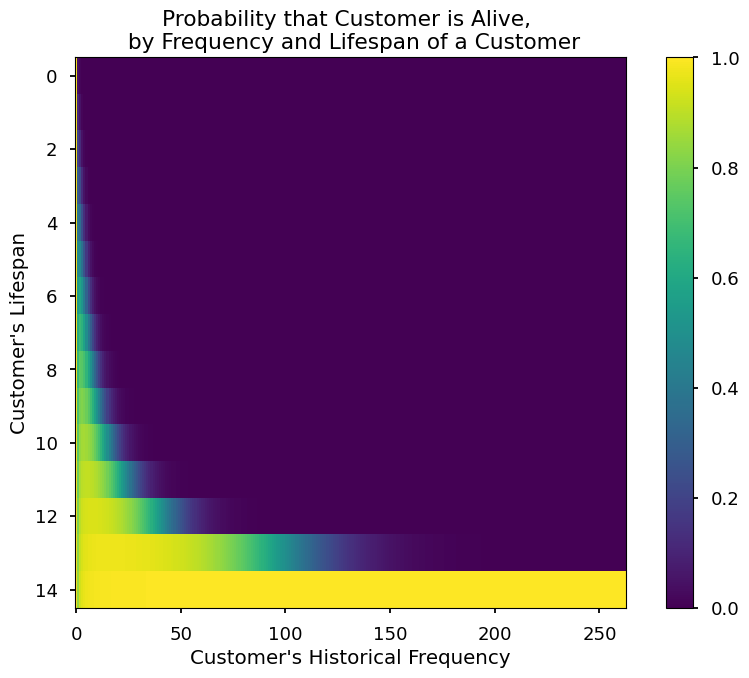

In [29]:
plot_probability_alive_matrix(bgf)
plt.title(f"Probability that Customer is Alive, \n by Frequency and Lifespan of a Customer")
plt.ylabel("Customer's Lifespan")
plt.show()

#### Inference

In [30]:
trans_data["predict_purchases_next_1_m"] = (
    bgf.conditional_expected_number_of_purchases_up_to_time(
        t=time_unit,
        frequency=trans_data["frequency"],
        recency=trans_data["lifespan"],
        T=trans_data["T"],
    )
)
trans_data["predict_probability_alive"] = bgf.conditional_probability_alive(
    frequency=trans_data["frequency"], recency=trans_data["lifespan"], T=trans_data["T"]
)
trans_data.sort_values(by="predict_purchases_next_1_m", ascending=False).head(10)

,userId,frequency,lifespan,T,average_sales_euro,CV,predict_purchases_next_1_m,predict_probability_alive
5389,402089433377497830,262,14.0,14,567.198473,148606.0,16.743371,0.999504
6718,497424748271724727,95,13.0,13,333.789474,31710.0,6.526133,0.998632
53342,3959435739687960670,72,11.0,11,623.333333,44880.0,5.743214,0.998194
5963,444730773991424385,54,9.0,9,352.962963,19060.0,5.134769,0.997590
45773,3405990330003900548,17,2.0,2,191.176471,3250.0,4.848680,0.992298
31378,2333573918598501663,70,13.0,13,467.785714,32745.0,4.826127,0.998142
74554,5569149071209566419,65,13.0,13,331.153846,21525.0,4.486122,0.997999
122945,9204248135457745700,65,13.0,13,389.384615,25310.0,4.486122,0.997999
103802,7763147301647778346,47,9.0,9,473.829787,22270.0,4.480870,0.997230
55732,4144786482233488865,68,14.0,14,227.500000,15470.0,4.391507,0.998087


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

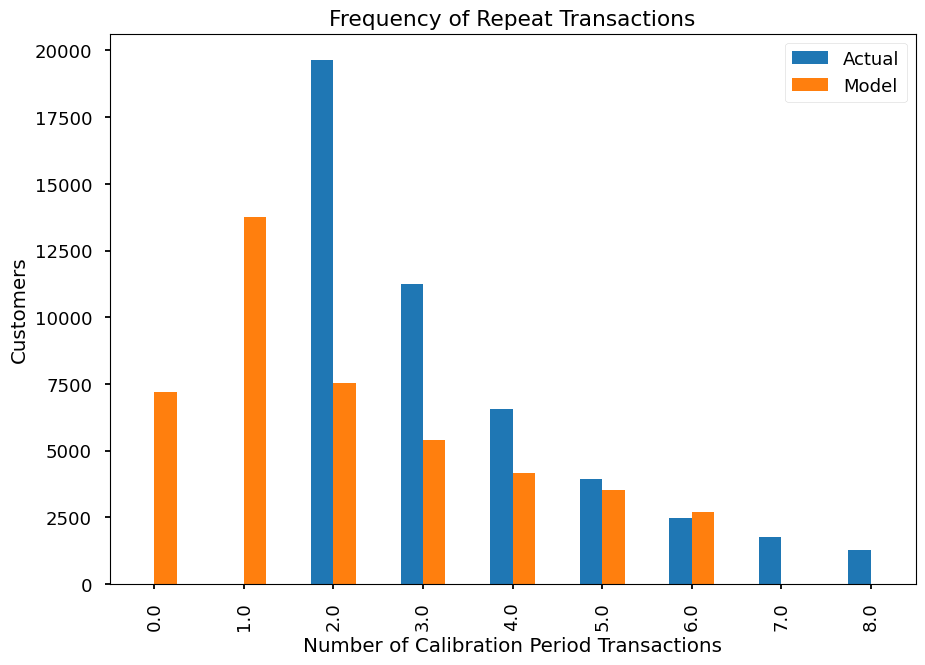

In [31]:
plot_period_transactions(bgf)

### Predicting future Sales of customer for CLV
The model assumes that
*  Customer are repeat customers only, i.e, customer who purchased again after their first transaction
* The frequency and average_sales_euro are not (strongly) correlated,  
* All monetary values are greater than zero

In [32]:
trans_data=trans_data[trans_data["average_sales_euro"]>0]
trans_data.set_index("userId")
trans_data[["frequency","average_sales_euro"]].corr()

,frequency,average_sales_euro
frequency,1.000000,-0.081475
average_sales_euro,-0.081475,1.000000


In [33]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(trans_data['frequency'],
        trans_data['average_sales_euro'])

bgf.fit(frequency=trans_data["frequency"], recency=trans_data["lifespan"], T=trans_data["T"])

<lifetimes.BetaGeoFitter: fitted with 51409 subjects, a: 0.13, alpha: 1.64, b: 0.72, r: 1.11>

In [63]:
look_forward_months = 3

trans_data["predicted_CLV"]=ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    trans_data['frequency'],
    trans_data['lifespan'],
    trans_data['T'],
    trans_data['average_sales_euro'],
    time=look_forward_months,
    discount_rate=0.0 
)
predicted_CLV = trans_data["predicted_CLV"].mean()

In [57]:
print(
    f"Starting from {period_end_date.strftime('%Y-%m-%d')}, the predicted CLV for {look_forward_months} months is {predicted_CLV:.2f} euros"
)
print(
    f"Assuming a profit margin of {profit_margin*100} percent, the profit from an average customer is {predicted_CLV*profit_margin:.2f} euros. \nTherefore, the marketing team should not spend more than {predicted_CLV*profit_margin:.2f} to acquire a new customer within the next {look_forward_months} months."
)

Starting from 2023-11-01, the predicted CLV for 3 months is 17685.27 euros
Assuming a profit margin of 5.0 percent, the profit from an average customer is 884.26 euros. 
Therefore, the marketing team should not spend more than 884.26 to acquire a new customer within the next 3 months.


## `More answers for the Marketing question`

The marketing team can predict the CLV for the entire customer base, for a given time frame.  Starting from 2023-11-01, the predicted CLV for 3 months is 17685.27 euros
Assuming a profit margin of 5.0 percent, the profit from an average customer is 884.26 euros. 
Therefore, the marketing team should not spend more than 884.26 to acquire a new customer within the next 3 months. 